In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time, os, sys, pickle
import seaborn as sns

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import bptt_rnn as bp  # RNN, learning algorithm, loss function etc
import plot_routines as pr  # plotting functions & directly related
import rot_utilities as ru  # random utilies

%load_ext autoreload
%autoreload 2

In [2]:
single_time_labels = ['0', 'A', '0', 'B', '0', 'C', '0', 'D', '0']
double_time_labels = []
double_time_labels_half = []
for stl in single_time_labels:
    double_time_labels.append(stl)
    double_time_labels.append(stl)
    double_time_labels_half.append(stl)
    double_time_labels_half.append('')
double_time_labels_blank = [x.replace('0', '') for x in double_time_labels]
assert len(double_time_labels_half) == len(double_time_labels)

## Create synthetic data
There are 8 possible values: 
- 0 $blank/0$
- 1 $A_1$
- 2 $A_2$
- 3 $B_1$
- 4 $B_2$
- 5 $C_1$
- 6 $C_2$
- 7 $D$

Data points are thus 8-dim vectors, with:

$z_{k, t} = (1_{0}, 1_{A_1}, 1_{A_2}, ... , 1_{D})$

where $k$ is the trial index, and $t$ is the trial time. Hence $|z_{k, t}| = 1 $ before white noise is added. Trials will be either $T=9$ data points long (single), and of form:

$ 0, A_{\alpha}, 0, B_{\alpha}, 0, C_{\beta}, 0, D, 0 $

or of length $T=18$ (double), and of form:

$ 0, 0, A_{\alpha}, A_{\alpha}, 0, 0, B_{\alpha}, B_{\alpha}, 0, 0, C_{\beta}, C_{\beta}, 0, 0, D, D, 0, 0 $

where $\alpha, \beta \in (1, 2)$, although one can use shorter sequences for testing (e.g. $0, A_{\alpha}, 0, B_{\alpha}, 0$). The expected sequence is $\alpha = \beta$, and the unexpected sequence is $\alpha \neq \beta$.

Network input $x_k = z_{k, 0:T-1}$ and output $y_k = z_{k, 1:T}$. 

In [3]:
d_dict = {  # data parameters dictionary
        'n_total': 1000,  # total number of data sequences
        'n_freq': 8,  # blank through D
        'n_times': 9,
        'doublesse': True,
        'ratio_train': 0.8,
        'ratio_exp': 0.5,  # probabilities of switching between alpha nd beta
        'noise_scale': 0.15
        }
if d_dict['doublesse']:
    eval_times = np.arange(4, 17)  # double
    d_dict['sequence'] = np.array(double_time_labels)
elif d_dict['doublesse'] is False:
    eval_times = np.arange(1, 8)  # single
    d_dict['sequence'] = np.array(single_time_labels)
t_dict = {'eval_times': eval_times}  # training paramter dictionary

freq_labels = ['0', 'A1', 'A2', 'B1', 'B2', 'C1', 'C2', 'D']
tmp0, tmp1 = bp.generate_synt_data(n_total=d_dict['n_total'], 
                                   n_times=d_dict['n_times'], 
                                   n_freq=d_dict['n_freq'],
                                   ratio_train=d_dict['ratio_train'], 
                                   ratio_exp=d_dict['ratio_exp'], 
                                   noise_scale=d_dict['noise_scale'], 
                                   double_length=d_dict['doublesse'])
x_train, y_train, x_test, y_test = tmp0
labels_train, labels_test = tmp1

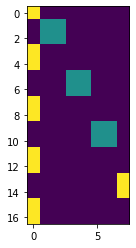

In [4]:
# x_train[:, :, 0] = 0
# x_test[:, :, 0] = 0
# y_train[:, :, 0] = 0
# y_test[:, :, 0] = 0
plt.imshow(y_train.mean(0))

## RNN Model with BPTT

#### RNN model:

$(x_t, s_{t-1}) \to s_t \to \hat{y}_t == y_t = x_{t+1} $

within one trial $k$. 
Equations:

$s_t = \tanh( U \cdot x_t + W \cdot s_{t-1})$


$\hat{y}_t = softmax(V \cdot s_t) = \left( \frac{e^{V_i \cdot s_t}}{\sum_i e^{V_i \cdot s_t}} \right), \; for \; i \in (0, A_1, A_2 ... D)$

where $U_{n x f}, W_{n x n}, V_{f x n}$ are matrices where $n$ is the number of RNN nodes and $f$ the number of input/output frequencies.

#### Training procedure:

The full sequence $x_k$ is forwarded through the model, yielding $\hat{y}_k$. This is used to compute the loss function $L$, which error is backpropagated through time (BPTT) to the parameters $\theta = (U, W, V)$ (updated with SGD probably). 
The loss function $L$ uses cross entropy and L1 regularisation:

$L_k = \sum_{\tau} - y_{k, \tau} \log \hat{y}_{k, \tau} + \lambda \cdot ||\theta||_1$

where $\tau$ defines the trial times that are taken into account for Loss computation. 

$ \begin{equation}
    \tau =
    \begin{cases}
      (0, 1, 2, ... 8), & \text{all} \\
      (1, 3, 5, 7), & \text{non-blank (nb)}\\
      (3, 5, 7), & \text{non-initial nb (ninb)}
    \end{cases}
  \end{equation}$

#### Initial conditions:

Tricky.. Maybe start on each trials with either zero, or small-magnitude noise, for $s_{k, -1}$? The sequence $0, A_{\alpha}, 0$ then should provide a sensible initialisation, needed for $B_{\alpha}$ prediction... ?  


#### Pseudo-algorithm:

    for $it$ in epochs:
        for $k$ in trials:
            for $t$ in times:
                rnn.forward($x_t$)
            compute loss $L_k$
            update parameters with BPTT


In [5]:
## Set training parameters:
t_dict['n_nodes'] = 20  # number of nodes in the RNN 
if d_dict['doublesse']:
    t_dict['learning_rate'] = 0.002  # algorithm lr
elif d_dict['doublesse'] is False:
    t_dict['learning_rate'] = 0.05
t_dict['bs'] = 1  # batch size
t_dict['n_epochs'] = 40  # training epochs
t_dict['l1_param'] = 5e-3  # L1 regularisation in loss function
t_dict['check_conv'] = False  # check for convergence (and abort if converged)
t_dict['conv_rel_tol'] = 5e-4  # assess convergence by relative difference between two epochs is smaller than this 


## Train one single model

In [188]:
## Initiate RNN model
rnn = bp.RNN(n_stim=d_dict['n_freq'], n_nodes=t_dict['n_nodes'])  # Create RNN class
opt = torch.optim.SGD(rnn.parameters(), lr=t_dict['learning_rate'])  # call optimiser from pytorhc
rnn.set_info(param_dict={**d_dict, **t_dict})

In [189]:
## Train with BPTT
rnn = bp.bptt_training(rnn=rnn, optimiser=opt, dict_training_params=t_dict,
                x_train=x_train, x_test=x_test, y_train=y_train, y_test=y_test)



  0%|          | 0/40 [00:00<?, ?it/s]

Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

Initialising training; start at epoch 0:   2%|▎         | 1/40 [00:04<03:07,  4.80s/it]

Epoch 1/40. Train loss: 8.589893:   2%|▎         | 1/40 [00:04<03:07,  4.80s/it]       

Epoch 1/40. Train loss: 8.589893:   5%|▌         | 2/40 [00:09<03:05,  4.89s/it]

Epoch 2/40. Train loss: 4.404918:   5%|▌         | 2/40 [00:09<03:05,  4.89s/it]

Epoch 2/40. Train loss: 4.404918:   8%|▊         | 3/40 [00:15<03:13,  5.22s/it]

Epoch 3/40. Train loss: 2.829237:   8%|▊         | 3/40 [00:19<04:02,  6.57s/it]

Training ended prematurely by user at epoch 3.
Results saved in RNN Class.


In [24]:
# rnn.save_model()
float(rnn.test_loss_ratio_ce[0].detach().numpy())

0.9260377883911133

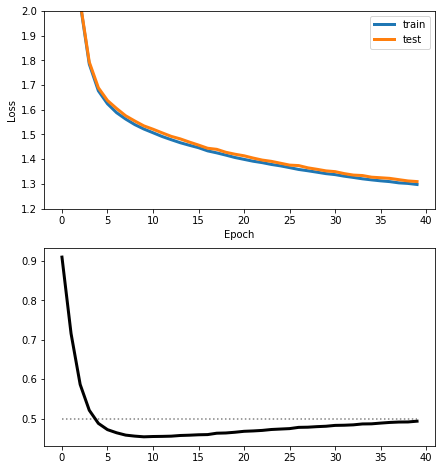

In [8]:
## Plot train/test loss during training
plt.rcParams['figure.figsize'] = (7, 8)
# plt.subplot(211)
ax_conv = pr.plot_train_test_perf(rnn_model=rnn, ax=plt.subplot(211))
plt.ylim([1.2, 2])

plt.subplot(212)
plt.plot(np.arange(rnn.info_dict['trained_epochs']), 
         np.zeros_like(rnn.test_loss_ratio_ce) + 0.5, c='grey', linestyle=':')
plt.plot(rnn.test_loss_ratio_ce, linewidth=3, c='k')


In [9]:
print(labels_test)

['21' '11' '22' '11' '22' '22' '22' '22' '22' '21' '22' '22' '11' '22'
 '12' '11' '11' '22' '11' '11' '11' '22' '22' '12' '22' '11' '11' '22'
 '22' '22' '11' '22' '11' '22' '21' '22' '11' '11' '11' '11' '11' '22'
 '11' '22' '11' '11' '12' '22' '22' '21' '21' '11' '11' '12' '22' '22'
 '21' '12' '12' '22' '21' '12' '12' '22' '11' '11' '22' '11' '22' '21'
 '22' '22' '11' '22' '12' '11' '22' '12' '11' '11' '22' '11' '11' '22'
 '22' '11' '11' '22' '11' '11' '12' '22' '12' '22' '21' '11' '22' '22'
 '11' '11' '22' '21' '22' '22' '21' '22' '11' '22' '11' '11' '11' '22'
 '11' '12' '11' '11' '22' '12' '22' '11' '11' '22' '21' '11' '12' '11'
 '12' '11' '21' '22' '12' '11' '11' '22' '11' '12' '22' '11' '22' '11'
 '22' '22' '12' '11' '21' '11' '11' '11' '21' '12' '11' '22' '11' '22'
 '11' '22' '21' '22' '22' '22' '22' '11' '22' '22' '21' '22' '12' '11'
 '22' '22' '11' '11' '21' '22' '11' '21' '11' '12' '11' '22' '22' '11'
 '21' '21' '21' '11' '12' '22' '11' '11' '21' '21' '12' '22' '21' '11'
 '22' 

torch.Size([17, 8])


(8.0, 0.0)

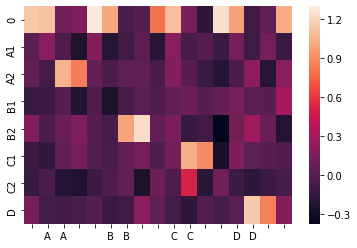

In [10]:
plt.rcParams['figure.figsize'] = (6, 4)
k = 0
print(x_test[k, :, :].shape)
# x_test[k, np.array([2, 3]), 1] = 0
# x_test[k, np.array([2, 3]), 7] = 1
# x_test[k, np.array([6, 7]), 3] = 0
# x_test[k, np.array([6, 7]), 7] = 0
ax_true_w = sns.heatmap(x_test[k, :, :].T, yticklabels=freq_labels,
            xticklabels=double_time_labels_blank[1:])
bottom, top = ax_true_w.get_ylim()
ax_true_w.set_ylim(bottom + 0.5, top - 0.5)

Trial type: ['12' '12' '12' '12' '12' '12' '12' '12' '12' '12' '12' '12' '12' '12'
 '12' '12' '12' '12' '12' '12' '12' '12' '12' '12' '12']


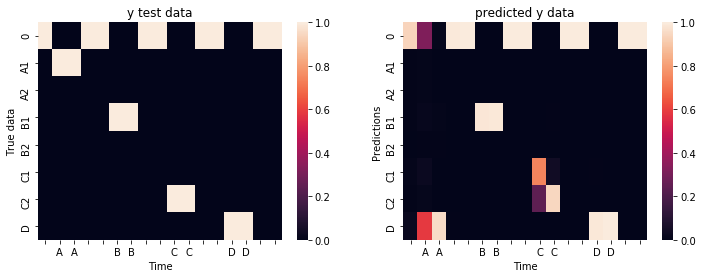

In [11]:
## Plot example test sample & prediction
k = np.where(labels_test == '12')[0]
print(f'Trial type: {labels_test[k]}')
pred = bp.compute_full_pred(x_test[k,:,:], model=rnn)  # computed forward predictions
plt.rcParams['figure.figsize'] = (12, 4)

plt.subplot(121)
true_data = y_test[k, :, :]
if type(k) != int and len(k) > 1:  # if multiple samples; average
    true_data = true_data.mean(0)
ax_true_w = sns.heatmap(true_data.numpy().T, yticklabels=freq_labels,
            xticklabels=double_time_labels_blank[1:])
bottom, top = ax_true_w.get_ylim()
ax_true_w.set_ylim(bottom + 0.5, top - 0.5)
plt.title("y test data"); plt.xlabel('Time'); plt.ylabel('True data')

plt.subplot(122)
ax_pred = sns.heatmap(pred.mean(0).detach().numpy().T, vmax=1, vmin=0, yticklabels=freq_labels,
           xticklabels=double_time_labels_blank[1:])  # average if multiple samples
bottom, top = ax_pred.get_ylim()
ax_pred.set_ylim(bottom + 0.5, top - 0.5)
plt.title("predicted y data"); plt.xlabel('Time'); plt.ylabel("Predictions");

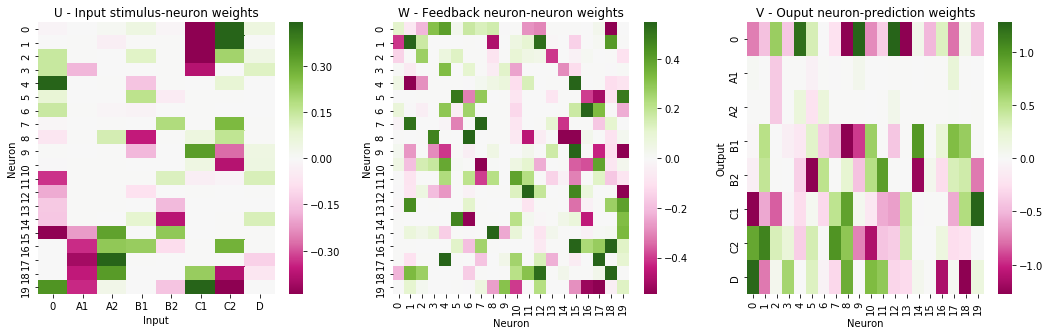

In [12]:
## Plot weight matrices U, W, V
plt.rcParams['figure.figsize'] = (18, 5)
w_order = pr.opt_leaf(w_mat=rnn.lin_input, dim=0)
_ = pr.plot_all_UWV(rnn_model=rnn, freq_labels=freq_labels, weight_order=w_order)

## Cross temporal decoding

Each sequence $seq_k$ has labels $\alpha, \beta$. We wish to decode $\alpha$ dynamically per time point, in a cross-temporal manner, from the RNN hidden state $s_t$. Id est, we will create a decoder $dec(t | \tau) = P(\alpha = 1 | \tau)_t$ that is trained at time $\tau$ but evaluated at time $t$. We can choose to train our decoder with either or both $(\alpha = \beta)$ and $(\alpha \neq \beta)$ sequences. To decode, we will use a linear SVM with L2 regularisation (from sklearn). 

#### Pseudocode

    forward run of all trials
    for $\tau$ in T:
        train P($\alpha$ | $\tau$)
        for t in T:
            evaluate P($\alpha$ | $\tau$)_t

In [14]:
score_mat, decoder_dict = bp.train_decoder(rnn_model=rnn, x_train=x_train, x_test=x_test,
                                           labels_train=labels_train, labels_test=labels_test)

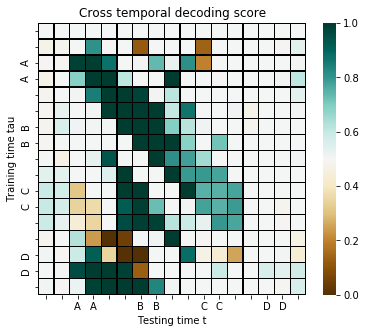

In [15]:
# score_mat[0, 5] = -10
plt.rcParams['figure.figsize'] = (6, 5)
ax_score = pr.plot_decoder_crosstemp_perf(score_matrix=score_mat, ax=plt.subplot(111),
                               ticklabels=double_time_labels_blank[:-1])

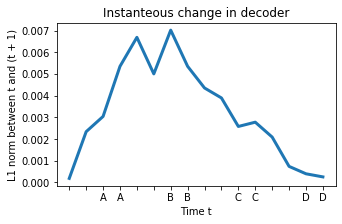

In [16]:
angle_change = np.zeros(x_train.shape[1] - 1)
for tau in range(x_train.shape[1] - 1):
    angle_change[tau] = np.sum(np.abs(decoder_dict[tau].coef_ - decoder_dict[tau + 1].coef_))
    
plt.rcParams['figure.figsize'] = (5, 3)
f, ax_ac = plt.subplots(1, 1)
ax_ac.plot(angle_change, linewidth=3)
ax_ac.set_xlabel('Time t'); ax_ac.set_ylabel('L1 norm between t and (t + 1)')
ax_ac.set_title('Instanteous change in decoder')
ax_ac.set_xticks(np.arange(len(angle_change)));
ax_ac.set_xticklabels(double_time_labels_blank[:-2]);

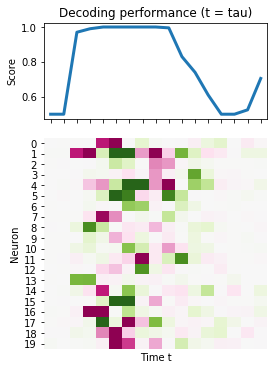

In [57]:
plt.rcParams['figure.figsize'] = (4, 6)
_, __ = pr.plot_dynamic_decoding_axes(rnn=rnn)

## Train & save multiple models

In [ ]:
## Train a lot of models for saving:
_ = bp.init_train_save_rnn(t_dict=t_dict, d_dict=d_dict, 
                           n_simulations=100, save_folder='models/5050_Xmodels/')

Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]


-----------
simulation 0/100


Epoch 39/40. Train loss: 1.449874: 100%|██████████| 40/40 [03:22<00:00,  5.05s/it]     
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-13-1817.data

-----------
simulation 1/100


Epoch 39/40. Train loss: 1.455682: 100%|██████████| 40/40 [03:22<00:00,  5.07s/it]     
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-13-1821.data

-----------
simulation 2/100


Epoch 39/40. Train loss: 1.393278: 100%|██████████| 40/40 [03:19<00:00,  4.99s/it]     
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-13-1824.data

-----------
simulation 3/100


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-13-1827.data

-----------
simulation 4/100


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-13-1831.data

-----------
simulation 5/100


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-13-1834.data

-----------
simulation 6/100


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-13-1837.data

-----------
simulation 7/100


Epoch 39/40. Train loss: 1.431865: 100%|██████████| 40/40 [03:17<00:00,  4.94s/it]     
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-13-1841.data

-----------
simulation 8/100


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-13-1844.data

-----------
simulation 9/100


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-13-1847.data

-----------
simulation 10/100


Epoch 39/40. Train loss: 1.440893: 100%|██████████| 40/40 [03:17<00:00,  4.94s/it]     
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-13-1851.data

-----------
simulation 11/100


Epoch 39/40. Train loss: 1.456754: 100%|██████████| 40/40 [03:17<00:00,  4.93s/it]     
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-13-1854.data

-----------
simulation 12/100


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-13-1857.data

-----------
simulation 13/100


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-13-1901.data

-----------
simulation 14/100


Epoch 39/40. Train loss: 1.46658: 100%|██████████| 40/40 [05:13<00:00,  7.83s/it]      
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-13-1907.data

-----------
simulation 15/100


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-13-1910.data

-----------
simulation 16/100


Epoch 39/40. Train loss: 1.451157: 100%|██████████| 40/40 [03:16<00:00,  4.92s/it]     
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-13-1913.data

-----------
simulation 17/100


Epoch 39/40. Train loss: 1.445346: 100%|██████████| 40/40 [03:15<00:00,  4.90s/it]     
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-13-1917.data

-----------
simulation 18/100


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-13-1920.data

-----------
simulation 19/100


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-13-1923.data

-----------
simulation 20/100


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-13-1927.data

-----------
simulation 21/100


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-13-1930.data

-----------
simulation 22/100


Epoch 39/40. Train loss: 1.442627: 100%|██████████| 40/40 [03:18<00:00,  4.95s/it]     
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-13-1934.data

-----------
simulation 23/100


Epoch 39/40. Train loss: 1.394946: 100%|██████████| 40/40 [03:16<00:00,  4.92s/it]     
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-13-1937.data

-----------
simulation 24/100


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-13-1940.data

-----------
simulation 25/100


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-13-1944.data

-----------
simulation 26/100


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-13-1947.data

-----------
simulation 27/100


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-13-1950.data

-----------
simulation 28/100


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-13-1954.data

-----------
simulation 29/100


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-13-1957.data

-----------
simulation 30/100


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-13-2000.data

-----------
simulation 31/100


Epoch 39/40. Train loss: 1.436846: 100%|██████████| 40/40 [03:17<00:00,  4.95s/it]     
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-13-2004.data

-----------
simulation 32/100


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-13-2007.data

-----------
simulation 33/100


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-13-2010.data

-----------
simulation 34/100


Epoch 39/40. Train loss: 1.450787: 100%|██████████| 40/40 [03:30<00:00,  5.27s/it]     
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-13-2014.data

-----------
simulation 35/100


Epoch 39/40. Train loss: 1.445503: 100%|██████████| 40/40 [03:36<00:00,  5.41s/it]     
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-13-2017.data

-----------
simulation 36/100


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-13-2021.data

-----------
simulation 37/100


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-13-2025.data

-----------
simulation 38/100


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-13-2029.data

-----------
simulation 39/100


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-13-2033.data

-----------
simulation 40/100


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-13-2036.data

-----------
simulation 41/100


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-13-2040.data

-----------
simulation 42/100


Epoch 39/40. Train loss: 1.396131: 100%|██████████| 40/40 [03:40<00:00,  5.51s/it]     
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-13-2044.data

-----------
simulation 43/100


Epoch 39/40. Train loss: 1.397591: 100%|██████████| 40/40 [03:33<00:00,  5.33s/it]     
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-13-2047.data

-----------
simulation 44/100


Epoch 12/40. Train loss: 1.628979:  30%|███       | 12/40 [01:03<02:29,  5.34s/it]     

In [220]:
## Retrain decoders:
_ = bp.train_multiple_decoders(rnn_folder='models/7525_100models/', n_samples=1000)




0it [00:00, ?it/s]

rnn_2020-05-11-1501.data
train labels  {'11': 200, '12': 200, '21': 200, '22': 200}


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



1it [00:01,  1.56s/it]

rnn_2020-05-11-1903.data





2it [00:03,  1.57s/it]

rnn_2020-05-11-1608.data


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



3it [00:04,  1.57s/it]

rnn_2020-05-11-1455.data


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



4it [00:06,  1.58s/it]

rnn_2020-05-11-1815.data





5it [00:07,  1.57s/it]

rnn_2020-05-11-1639.data


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



6it [00:09,  1.62s/it]

rnn_2020-05-11-1910.data





7it [00:11,  1.63s/it]

rnn_2020-05-11-1808.data





8it [00:12,  1.64s/it]

rnn_2020-05-11-1941.data





9it [00:14,  1.61s/it]

rnn_2020-05-11-1950.data





10it [00:15,  1.58s/it]

rnn_2020-05-11-1650.data


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



11it [00:17,  1.57s/it]

rnn_2020-05-11-1445.data


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



12it [00:19,  1.62s/it]

rnn_2020-05-11-1750.data





13it [00:21,  1.76s/it]

rnn_2020-05-11-1515.data





14it [00:23,  1.75s/it]

rnn_2020-05-11-1458.data





15it [00:24,  1.66s/it]

rnn_2020-05-11-1629.data





16it [00:25,  1.60s/it]

rnn_2020-05-11-1835.data


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



17it [00:27,  1.56s/it]

rnn_2020-05-11-1528.data





18it [00:29,  1.68s/it]

rnn_2020-05-11-1558.data


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



19it [00:31,  1.68s/it]

rnn_2020-05-11-1646.data


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



20it [00:32,  1.66s/it]

rnn_2020-05-11-1452.data





21it [00:34,  1.67s/it]

rnn_2020-05-11-1753.data





22it [00:36,  1.72s/it]

rnn_2020-05-11-1947.data





23it [00:37,  1.73s/it]

rnn_2020-05-11-1619.data


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



24it [00:39,  1.73s/it]

rnn_2020-05-11-2016.data





25it [00:41,  1.79s/it]

rnn_2020-05-11-1626.data





26it [00:43,  1.79s/it]

rnn_2020-05-11-1508.data





27it [00:45,  1.80s/it]

rnn_2020-05-11-1856.data





28it [00:47,  1.79s/it]

rnn_2020-05-11-1900.data





29it [00:48,  1.74s/it]

rnn_2020-05-11-1442.data





30it [00:50,  1.75s/it]

rnn_2020-05-11-1838.data


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



31it [00:52,  1.71s/it]

rnn_2020-05-11-1832.data





32it [00:53,  1.71s/it]

rnn_2020-05-11-1541.data





33it [00:55,  1.72s/it]

rnn_2020-05-11-1538.data





34it [00:57,  1.72s/it]

rnn_2020-05-11-1548.data





35it [00:59,  1.76s/it]

rnn_2020-05-11-1554.data


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



36it [01:00,  1.77s/it]

rnn_2020-05-11-1636.data





37it [01:02,  1.70s/it]

rnn_2020-05-11-1525.data


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



38it [01:03,  1.67s/it]

rnn_2020-05-11-2008.data


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



39it [01:05,  1.66s/it]

rnn_2020-05-11-1632.data





40it [01:07,  1.64s/it]

rnn_2020-05-11-1545.data





41it [01:08,  1.68s/it]

rnn_2020-05-11-1811.data





42it [01:10,  1.61s/it]

rnn_2020-05-11-1730.data


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



43it [01:12,  1.65s/it]

rnn_2020-05-11-1932.data





44it [01:13,  1.63s/it]

rnn_2020-05-11-1822.data


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



45it [01:15,  1.64s/it]

rnn_2020-05-11-1925.data


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



46it [01:17,  1.63s/it]

rnn_2020-05-11-1720.data





47it [01:18,  1.60s/it]

rnn_2020-05-11-1605.data





48it [01:20,  1.58s/it]

rnn_2020-05-11-2005.data





49it [01:21,  1.54s/it]

rnn_2020-05-11-2001.data


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



50it [01:23,  1.55s/it]

rnn_2020-05-11-1740.data





51it [01:24,  1.55s/it]

rnn_2020-05-11-1737.data





52it [01:26,  1.54s/it]

rnn_2020-05-11-1505.data





53it [01:27,  1.53s/it]

rnn_2020-05-11-1642.data


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



54it [01:29,  1.53s/it]

rnn_2020-05-11-1922.data





55it [01:30,  1.53s/it]

rnn_2020-05-11-1448.data





56it [01:32,  1.53s/it]

rnn_2020-05-11-1919.data





57it [01:33,  1.53s/it]

rnn_2020-05-11-1957.data


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



58it [01:35,  1.55s/it]

rnn_2020-05-11-1842.data





59it [01:37,  1.57s/it]

rnn_2020-05-11-1700.data





60it [01:38,  1.57s/it]

rnn_2020-05-11-1944.data





61it [01:40,  1.59s/it]

rnn_2020-05-11-1929.data





62it [01:41,  1.64s/it]

rnn_2020-05-11-1935.data





63it [01:43,  1.68s/it]

rnn_2020-05-11-1612.data





64it [01:45,  1.70s/it]

rnn_2020-05-11-1825.data





65it [01:47,  1.70s/it]

rnn_2020-05-11-1723.data





66it [01:48,  1.63s/it]

rnn_2020-05-11-1804.data





67it [01:50,  1.58s/it]

rnn_2020-05-11-1716.data





68it [01:51,  1.55s/it]

rnn_2020-05-11-1703.data





69it [01:53,  1.56s/it]

rnn_2020-05-11-1710.data





70it [01:54,  1.55s/it]

rnn_2020-05-11-1518.data





71it [01:56,  1.55s/it]

rnn_2020-05-11-1713.data


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



72it [01:57,  1.58s/it]

rnn_2020-05-11-1938.data





73it [01:59,  1.59s/it]

rnn_2020-05-11-1916.data





74it [02:01,  1.64s/it]

rnn_2020-05-11-1828.data


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



75it [02:03,  1.72s/it]

rnn_2020-05-11-1601.data





76it [02:04,  1.72s/it]

rnn_2020-05-11-1706.data


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



77it [02:07,  1.99s/it]

rnn_2020-05-11-1757.data





78it [02:10,  2.25s/it]

rnn_2020-05-11-1656.data





79it [02:12,  2.15s/it]

rnn_2020-05-11-1913.data





80it [02:14,  2.10s/it]

rnn_2020-05-11-1846.data





81it [02:16,  2.00s/it]

rnn_2020-05-11-1818.data


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



82it [02:17,  1.96s/it]

rnn_2020-05-11-1907.data





83it [02:19,  1.93s/it]

rnn_2020-05-11-1521.data





84it [02:21,  1.82s/it]

rnn_2020-05-11-2012.data





85it [02:22,  1.72s/it]

rnn_2020-05-11-1747.data





86it [02:24,  1.72s/it]

rnn_2020-05-11-1849.data


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



87it [02:26,  1.78s/it]

rnn_2020-05-11-1743.data





88it [02:28,  1.80s/it]

rnn_2020-05-11-1511.data


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



89it [02:30,  1.98s/it]

rnn_2020-05-11-1727.data





90it [02:32,  1.96s/it]

rnn_2020-05-11-1531.data





91it [02:34,  1.90s/it]

rnn_2020-05-11-1535.data





92it [02:36,  1.91s/it]

rnn_2020-05-11-1954.data





93it [02:38,  1.93s/it]

rnn_2020-05-11-1801.data





94it [02:40,  1.94s/it]

rnn_2020-05-11-1551.data





95it [02:42,  1.93s/it]

rnn_2020-05-11-1615.data





96it [02:44,  1.96s/it]

rnn_2020-05-11-1733.data





97it [02:46,  1.96s/it]

rnn_2020-05-11-1853.data





98it [02:48,  1.99s/it]

rnn_2020-05-11-1653.data





99it [02:50,  1.96s/it]

rnn_2020-05-11-1623.data





100it [02:52,  1.72s/it]


In [221]:
agg_conv, agg_score = {}, {}
agg_conv[75] = bp.aggregate_convergence(model_folder='models/7525_100models/')
agg_score[75] = bp.aggregate_score_mats(model_folder='models/7525_100models/')
agg_conv[50] = bp.aggregate_convergence(model_folder='models/5050_66models/')
agg_score[50] = bp.aggregate_score_mats(model_folder='models/5050_66models/')

/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


<Figure size 720x576 with 0 Axes>

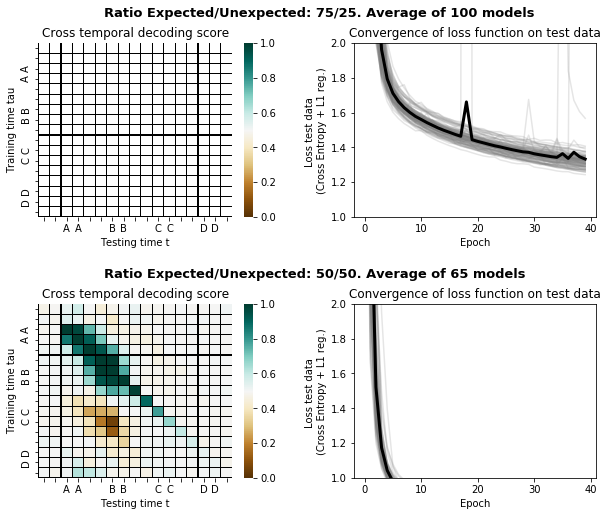

In [222]:
plt.rcParams['figure.figsize'] = (10, 8)
plt.subplots_adjust(hspace=0.6)
fig, ax_agg = plt.subplots(2, 2)
for i_ax, kk in enumerate(list(agg_conv.keys())):
    model_selection = np.arange(agg_score[kk].shape[0])
    model_selection = agg_score[kk][:, 11, 6] < 0.4
#     plot_mat = np.mean(np.abs(agg_score[kk][model_selection, :, :] - 0.5) + 0.5, 0)
    plot_mat = np.mean(agg_score[kk][model_selection, :, :], 0)
    pr.plot_decoder_crosstemp_perf(score_matrix=plot_mat, 
                                   ax=ax_agg[i_ax][0], ticklabels=double_time_labels_blank[:-1])

    ax_agg[i_ax][1].plot(agg_conv[kk]['test'][:100, :].T, alpha=0.2, c='grey')
    ax_agg[i_ax][1].plot(np.mean(agg_conv[kk]['test'], 0), linewidth=3, c='k')
    ax_agg[i_ax][1].set_ylim([1, 2]); 
    ax_agg[i_ax][1].set_ylabel('Loss test data \n(Cross Entropy + L1 reg.)')
    ax_agg[i_ax][1].set_xlabel('Epoch'); ax_agg[i_ax][1].set_title('Convergence of loss function on test data');
    ax_agg[i_ax][1].text(s=f'Ratio Expected/Unexpected: {kk}/{100 - kk}. Average of {agg_score[kk].shape[0]} models',
                         x=-46, y=2.15, fontdict={'weight': 'bold', 'fontsize': 13})
fig.subplots_adjust(hspace=0.5, wspace=0.3)
plt.savefig('results/average_results_new.pdf', bbox_inches='tight')

In [225]:
for ii, ll in enumerate(double_time_labels_blank[:-1]):
    print(ii, ll)

0 
1 
2 A
3 A
4 
5 
6 B
7 B
8 
9 
10 C
11 C
12 
13 
14 D
15 D
16 


Text(0.5, 1.0, "Train time tau=11, test time t=6\n (['C', 'C', '0', '0', 'D', 'D', '0', '0'])")

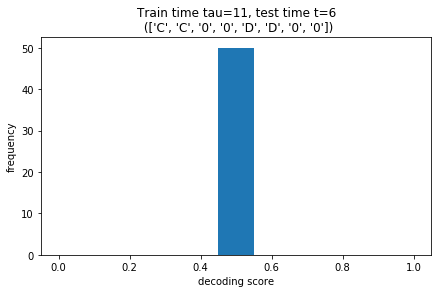

In [226]:
plt.rcParams['figure.figsize'] = (7, 4)
train_time = 11
test_time = 6
hist_arr = agg_score[75][:, train_time, test_time]
plt.hist(hist_arr, bins=np.linspace(0, 1, 21));
plt.scatter(np.mean(hist_arr), 25, marker='v', color='k', s=60)
plt.xlabel('decoding score'); plt.ylabel('frequency'); 
plt.title(f'Train time tau={train_time}, test time t={test_time}\n ({double_time_labels[train_time-1:]})')

In [200]:
rnn_folder = 'models/7525_100models/'
inds_selection = np.where(agg_score[75][:, train_time, test_time] > 0.9)[0]
list_rnns = [x for x in os.listdir(rnn_folder) if x[-5:] == '.data']
# rnn_name = list_rnns[inds_selection[0]]
rnn_name = 'rnn_2020-05-11-1501.data'
with open(rnn_folder + rnn_name, 'rb') as f:
    rnn = pickle.load(f)
# assert rnn.decoding_crosstemp_score[train_time, test_time] > 0.9

In [169]:
# import importlib
# importlib.reload(bp)
_, __  = bp.train_single_decoder_new_data(rnn=rnn, ratio_expected=0.5)

/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


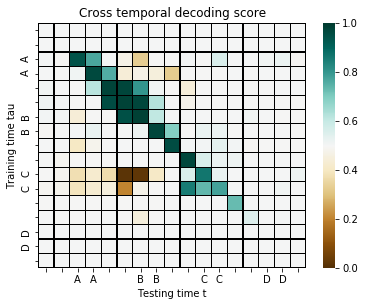

In [201]:
plt.rcParams['figure.figsize'] = (6, 4.5)
pr.plot_decoder_crosstemp_perf(score_matrix=rnn.decoding_crosstemp_score, 
                               ax=plt.subplot(111), 
                               ticklabels=double_time_labels_blank[:-1])


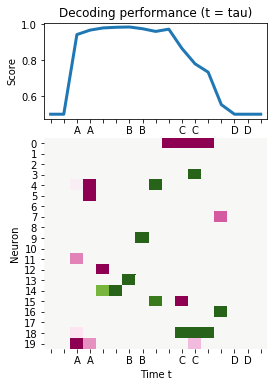

In [203]:
plt.rcParams['figure.figsize'] = (4, 6)
_, __ = pr.plot_dynamic_decoding_axes(rnn=rnn, ticklabels=double_time_labels_blank[:-1])

In [143]:
rnn.decoder_dict[1].coef_

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]])

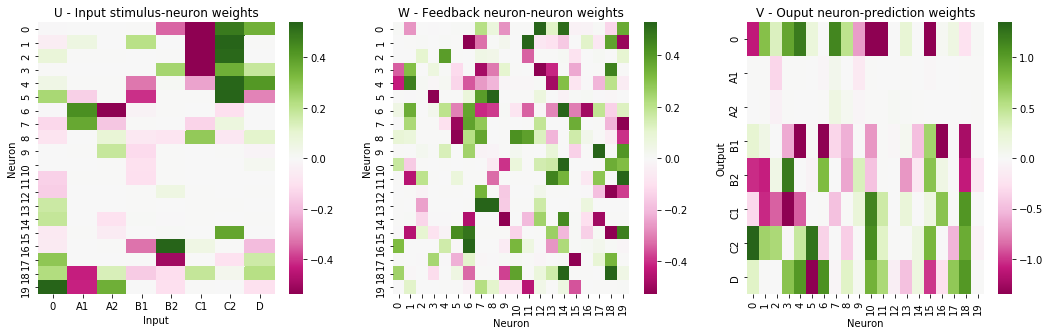

In [59]:

plt.rcParams['figure.figsize'] = (18, 5)
w_order = pr.opt_leaf(w_mat=rnn.lin_input, dim=0)
_ = pr.plot_all_UWV(rnn_model=rnn, freq_labels=freq_labels, weight_order=w_order)